In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import os
import shutil

In [10]:
# Assuming 'path/to/data' contains your images
data_dir = '/content/drive/MyDrive/signatures'

In [14]:
# Create lists to store file paths and corresponding labels
image_paths = []
labels = []

# Iterate through your data directory and collect file paths and labels
for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_name in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_name)
            image_paths.append(image_path)
            labels.append(label)

# Split the data into training and validation sets
train_paths, validation_paths, train_labels, validation_labels = train_test_split(
    image_paths, labels, test_size=0.2)

# Create directories for 'train' and 'validation'
train_data_dir = '/content/drive/MyDrive/sign_data_train'
validation_data_dir = '/content/drive/MyDrive/sign_data_val'
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(validation_data_dir, exist_ok=True)

# Move images to 'train' or 'validation' directories based on the split
for path, label in zip(train_paths, train_labels):
    dest_dir = os.path.join(train_data_dir, label)
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy(path, dest_dir)

for path, label in zip(validation_paths, validation_labels):
    dest_dir = os.path.join(validation_data_dir, label)
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy(path, dest_dir)


In [15]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/sign_data_train',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/sign_data_val',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 2599 images belonging to 2 classes.
Found 1272 images belonging to 2 classes.


In [2]:
# Define the CNN architecture
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))  # Adjust input shape
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
# Train the model
model.fit(train_generator, epochs=10, validation_data=val_generator)

Epoch 1/10
66/66 [==============================] - 27s 376ms/step - loss: 0.7655 - accuracy: 0.4979 - val_loss: 0.6925 - val_accuracy: 0.5822
Epoch 2/10
66/66 [==============================] - 27s 409ms/step - loss: 0.6954 - accuracy: 0.5069 - val_loss: 0.6936 - val_accuracy: 0.4783
Epoch 3/10
66/66 [==============================] - 24s 363ms/step - loss: 0.6937 - accuracy: 0.5064 - val_loss: 0.6936 - val_accuracy: 0.4783
Epoch 4/10
66/66 [==============================] - 26s 396ms/step - loss: 0.6927 - accuracy: 0.5149 - val_loss: 0.6922 - val_accuracy: 0.5217
Epoch 5/10
66/66 [==============================] - 23s 355ms/step - loss: 0.6923 - accuracy: 0.5182 - val_loss: 0.6898 - val_accuracy: 0.4991
Epoch 6/10
66/66 [==============================] - 25s 386ms/step - loss: 0.6455 - accuracy: 0.6428 - val_loss: 0.5584 - val_accuracy: 0.7202
Epoch 7/10
66/66 [==============================] - 23s 353ms/step - loss: 0.6035 - accuracy: 0.6878 - val_loss: 0.4852 - val_accuracy: 0.7769

In [ ]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

In [ ]:
# Make predictions on the validation set
y_pred = model.predict(val_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Convert ground truth to classes
y_true = val_generator.classes

              precision    recall  f1-score   support

     Genuine       0.53      0.62      0.57       276
      Forged       0.49      0.40      0.44       253

    accuracy                           0.51       529
   macro avg       0.51      0.51      0.50       529
weighted avg       0.51      0.51      0.51       529



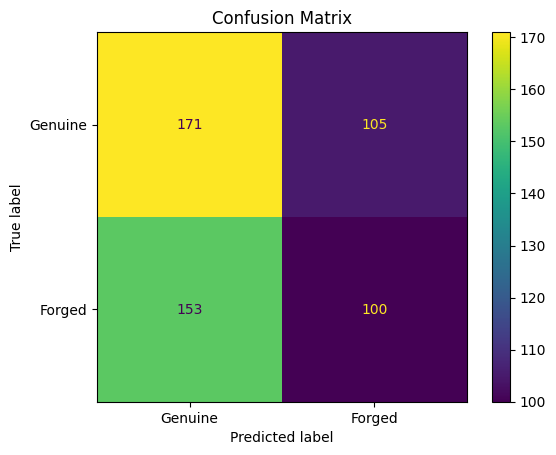

In [44]:
# Print classification report
classification_rep = classification_report(y_true, y_pred_classes, target_names=["Genuine", "Forged"], zero_division=1)
print(classification_rep)

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Genuine", "Forged"])
disp.plot(cmap='viridis', values_format='d')

plt.title('Confusion Matrix')
plt.show()

The dataset used for the is [CEDAR Signatures dataset](https://www.kaggle.com/datasets/shreelakshmigp/cedardataset) with following information:

There are two folders

1. full_forg: Contains 1320 forgery signatures (24 forgeries for each of 55 writers).
2. full_org: Contains 1320 genuine signatures (24 genuines for each of 55 writers).

The dataset was divided into train and validation sets in the ratio of 80:20, where 80% is used for training and remaining 20% for validation set.

The ImageDataGenerator class was used for image pre-processing of the images for both training and validation.
> *   Rescaling: The pixel values of the images are rescaled to the range [0, 1] by dividing each pixel value by 255. This is done using the rescale parameter in ImageDataGenerator.
> *   Data Augmentation: Data augmentation is applied to the training set to artificially increase the size of the dataset and improve the model's generalization. It includes shear range, zoom range, and horizontal flip.
> * Image Size: The images are resized to the target size of (150, 150) using the target_size parameter in the flow_from_directory method.




**Experimentation 1 output**:

Parameters:
* batch size=32
* model.add(layers.Dense(128, activation='relu'))     
* activation function: relu, sigmoid
* optimizer: Adam
* loss: binary_cross entropy
* epochs: 10


> Validation Loss: 0.4328639805316925,  
> Validation Accuracy: 79.21604944229126




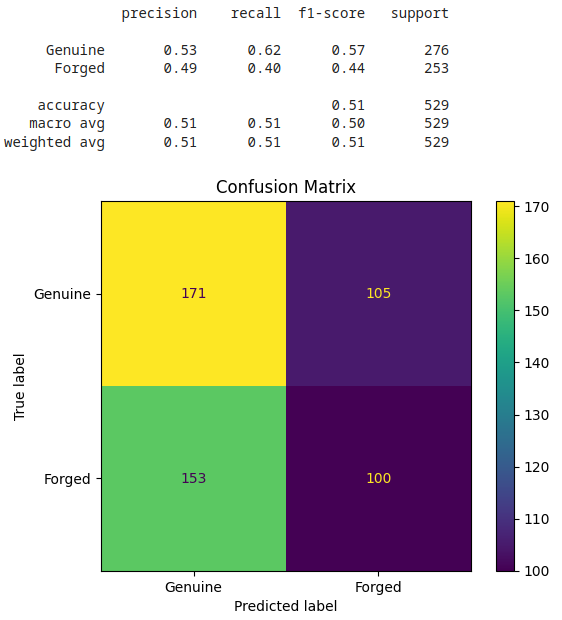